# SR3 Reader

* Reads data from SR3 file (HDF).
* Return groups, wells, special and grid properties list.
* Return 2D and 3D Time vector.
* Return a 2D or 3D property.
* Save all data to a csv file.

In [2]:
import h5py
from datetime import datetime, timedelta
import re
import numpy as np
from scipy import interpolate
from collections import OrderedDict
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib
params = {'font.size'     : 10,
          'figure.figsize':(8.0, 5.0),
          'lines.linewidth': 1.,
          'lines.markersize': 7,}
matplotlib.rcParams.update(params)

%matplotlib inline

In [3]:
# f = h5py.File(r'..\sr3\base_case_3a.sr3', 'r')
# f = h5py.File(r'..\sr3\imex_2phi2k.sr3', 'r')
f = h5py.File(Path(r'..\..\tests\sr3\base_case_3a.sr3').resolve())

In [4]:
# f.close()

In [5]:
def _list_hdf_():
    print("Main Groups in the HDF file:")
    for dataset in f.keys():
        print(f'  {dataset}')

    print("\nAll Groups in the HDF file:")
    def get_type(name):
        print(f'   {name:}\t{type(f[name])}')
    f.visit(get_type)

In [6]:
x = type(f['General/HistoryTable'])
isinstance(f['General/HistoryTable'], str)

False

In [7]:
_list_hdf_()

Main Groups in the HDF file:
  General
  SpatialProperties
  Tables
  TimeSeries

All Groups in the HDF file:
   General	<class 'h5py._hl.group.Group'>
   General/ComponentTable	<class 'h5py._hl.dataset.Dataset'>
   General/EventTable	<class 'h5py._hl.dataset.Dataset'>
   General/HistoryTable	<class 'h5py._hl.dataset.Dataset'>
   General/MasterTimeTable	<class 'h5py._hl.dataset.Dataset'>
   General/NameRecordTable	<class 'h5py._hl.dataset.Dataset'>
   General/TableAssociations	<class 'h5py._hl.dataset.Dataset'>
   General/UnitConversionTable	<class 'h5py._hl.dataset.Dataset'>
   General/UnitsTable	<class 'h5py._hl.dataset.Dataset'>
   SpatialProperties	<class 'h5py._hl.group.Group'>
   SpatialProperties/000000	<class 'h5py._hl.group.Group'>
   SpatialProperties/000000/BKRGCL	<class 'h5py._hl.dataset.Dataset'>
   SpatialProperties/000000/BKRGRL	<class 'h5py._hl.dataset.Dataset'>
   SpatialProperties/000000/BKROCRW	<class 'h5py._hl.dataset.Dataset'>
   SpatialProperties/000000/BKROCW	<cl

## Master Data

* Make a day/date from timestep function

In [8]:
dataset = f['General/MasterTimeTable']
day_list = {number:days for (number,days) in zip(dataset['Index'], dataset['Offset in days'])}

def parse_date(date):
    date_string = str(date)
    integer_part = int(date_string.split('.')[0])
    decimal_part = float("0." + date_string.split('.')[1])

    parsed_date = datetime.strptime(str(integer_part), "%Y%m%d")
    fraction_of_day = timedelta(days=decimal_part)
    return parsed_date + fraction_of_day

dataset = f['General/MasterTimeTable']
date_list = {number:parse_date(date) for (number,date) in zip(dataset['Index'], dataset['Date'])}

In [9]:
dataset = f['General/UnitsTable']
unit_list = {number:{'type':name.decode().lower(), 'internal':in_name.decode(), 'current':out_name.decode(), 'conversion':dict()} for (number,name,in_name,out_name) in zip(dataset['Index'],dataset['Dimensionality'],dataset['Internal Unit'],dataset['Output Unit'])}

dataset = f['General/UnitConversionTable']
for (number, name, gain, offset) in zip(dataset['Dimensionality'],dataset['Unit Name'],dataset['Gain'],dataset['Offset']):
    unit_list[number]['conversion'][name.decode()] = (1./gain, offset * (-1.))

for d in unit_list.values():
    if d['internal'] != d['current']:
        gain, offset = d['conversion'][d['internal']]
        for k in d['conversion']:
            g, o = d['conversion'][k]
            d['conversion'][k] = (g / gain, o - offset)

for unit in unit_list.values():
    if unit['internal'] not in unit['conversion']:
        unit['conversion'][unit['internal']] = (1.,0.)

In [10]:
if 'ComponentTable' in f['General']:
    dataset = f['General/ComponentTable']
    component_list = {(number+1):name[0].decode() for (number,name) in enumerate(dataset[:])}
else:
    component_list = {}

def replace_components_property_list(property_list):
    pattern = re.compile(r'\((\d+)\)')
    def replace(match):
        number = int(match.group(1))
        return f'({str(component_list.get(number, match.group(1)))})'
    return {pattern.sub(replace, k):v for k,v in property_list.items()}

In [11]:
dataset = f['General/NameRecordTable']
property_list = dict()
for (keyword,name,long_name,dimensionality) in zip(dataset['Keyword'],dataset['Name'],dataset['Long Name'],dataset['Dimensionality']):
    if keyword != '':
        keyword = keyword.decode()
        name = name.decode()
        long_name = long_name.decode()
        dimensionality = dimensionality.decode()
        if keyword[-2:] == '$C':
            for c in component_list.values():
                property_list[f'{keyword[:-2]}({c})'] = {'name':name.replace('$C', f' ({c})'), 'long name':long_name.replace('$C', f' ({c})'), 'dimensionality_string':dimensionality}
        else:
            property_list[keyword] = {'name':name, 'long name':long_name, 'dimensionality_string':dimensionality}
_ = property_list.pop('')

In [12]:
def _unit_from_dimensionality(dimensionality_string):
    if dimensionality_string == '':
        return ''
    unit = ''
    if dimensionality_string[0] == '-':
        unit = '1'
    d = ''
    for c in dimensionality_string:
        if c == '|':
            unit = unit + unit_list[int(d)]['current']
            d = ''
        elif c == '-':
            unit = unit + '/'
        else:
            d = d + c
    return unit

def _unit_conversion_from_dimensionality(dimensionality_string, is_delta=False):
    if dimensionality_string == '':
        return (1., 0.)
    gain = 1.
    offset = 0.
    inverse = False
    if dimensionality_string[0] == '-':
        inverse = True
    d = ''
    for c in dimensionality_string:
        if c == '|':
            unit = unit_list[int(d)]['current']
            gain_new, offset_new = unit_list[int(d)]['conversion'][unit]
            d = ''
            if inverse:
                gain = gain / gain_new
                offset = 0.
            else:
                gain = gain * gain_new
                if is_delta:
                    offset = 0.
                else:
                    offset = offset * gain_new + offset_new
        elif c == '-':
            inverse = True
        else:
            d = d + c
    return (gain, offset)

def _update_properties_units():
    for p in property_list:
        property_list[p]['conversion'] = _unit_conversion_from_dimensionality(property_list[p]['dimensionality_string'])
        property_list[p]['unit'] = _unit_from_dimensionality(property_list[p]['dimensionality_string'])

def _get_unit_type_number(dimensionality):
    if isinstance(dimensionality, str):
        d = [d for d in unit_list if unit_list[d]['type'] == dimensionality.lower()]
        if len(d) == 0:
            raise ValueError(f'{dimensionality} is not a valid unit type.')
        if len(d) > 1:
            raise ValueError(f'{dimensionality} found more than once. Check code.')
        return d[0]
    else:
        return dimensionality

def set_current_unit(dimensionality, unit):
    dimensionality = _get_unit_type_number(dimensionality)
    if unit not in unit_list[dimensionality]['conversion']:
        raise ValueError(f"{unit} is not a valid unit for {unit_list[dimensionality]['type']}.")
    unit_list[dimensionality]['current'] = unit
    _update_properties_units()

def get_current_units():
    for d in unit_list.values():
        print(f'{d["type"]}: {d["current"]}')

In [13]:
def _get_unit_numbers(unit):
    out = list()
    for u in unit_list:
        for c in unit_list[u]['conversion']:
            if unit == c:
                out.append(u)
    return out

def add_new_unit(old_unit, new_unit, gain, offset):
    unit_numbers = _get_unit_numbers(old_unit)
    if len(unit_numbers) == 0:
        raise ValueError(f'{old_unit} was not found in Units Table.')

    for u in unit_numbers:
        g, o = unit_list[u]['conversion'][old_unit]
        unit_list[u]['conversion'][new_unit] = (g * gain, o * gain + offset)

In [14]:
def get_property_description(property_):
    return {'description': property_list[property_]['name'],
            'long description': property_list[property_]['long name'],
            'unit': property_list[property_]['unit']
            }

def get_property_unit(property_):
    return property_list[property_]['unit']

In [15]:
additional_units = [('m3', 'MMm3', (1.e-6, 0.0)),
                    ('bbl', 'MMbbl', (1.e-6, 0.0)),
                    ('kg/cm2', 'kgf/cm2', (1., 0.0)),
                    ]

for old, new, (gain, offset) in additional_units:
    add_new_unit(old, new, gain, offset)

set_current_unit('pressure','kgf/cm2')
get_current_units()

time: day
temperature: C
pressure: kgf/cm2
length: m
property volume: m3
permeability: md
mass: kg
molar mass: gmole
viscosity: cp
energy: J
well liquid volume: m3
well gas volume: m3
well rate time: day
interfacial tension: dyne/cm
electrical current: A
electrical power: J/day
electrical potential: V
electrical resistance: ohm
electrical conductivity: S/m
electrical energy: J
temperature difference: C
diffusion/dispersion coeff.: cm2/s
concentration: kg/m3
molar concentration: gmole/m3


### Property Formulas (todo)

* Basic
    * 1035: sum (2 parameters)
    * 1037: sum (3 parameters)

* Time derivatives
    * 1040: derivative (1 parameter)
    * 1045: monthly derivative (1 parameter)
    * 1046: quarterly derivative (1 parameter)
    * 1047: yearly derivative (1 parameter)
    * 1048: daily derivative (1 parameter)
    * 1049: weekly derivative (1 parameter)

* Percentage
    * 1055: A*100 (1 parameter)

* Division
    * 1060: division (2 parameters)
    * 1062: division * 100 (2 parameters) <= used with on-fraction

    * 1080: division (2 parameters)

* Previous month
    * 1121: monthly derivative of previous month (1 parameter)
    * 1122: yearly derivative of previous month (1 parameter)

* Grid properties(?)
    * 1130: A*grid height (1 parameter)
    * 1140: A/(B*C) ? (3 parameters)
    * 1160: A*B (2 parameters)
    * 1200: ternary (2 parameters)
    * 1210: sum over layers (1 parameter)

* Per sector
    * 1110: ??? (1 parameter) <= per sector
    * 1245: ??? (1 parameter) <= per sector
    * 1246: derivative of 1245 (1 parameter) 



## Common Routines

In [16]:
def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False

def remove_duplicates(input_list):
    unique_items = OrderedDict()
    for item in input_list:
        unique_items[item] = None
    return list(unique_items.keys())

## Time Series

In [17]:
_element = {'special':{'':0}, 'grid':{'MATRIX':0}}
_parent = dict()
_connection = dict()
_property = dict()
_timestep = dict()
_day = dict()
_date = dict()

def _get_dataset(element_type, dataset_string):
    if element_type == 'grid':
        s = f'SpatialProperties/{dataset_string.upper()}'
    else:
        el_type_string = element_type.upper()
        if element_type == 'special':
            el_type_string = el_type_string + ' HISTORY'
        else:
            el_type_string = el_type_string + 'S'
        s = f'TimeSeries/{el_type_string}/{dataset_string}'
    if s in f:
        return f[s]
    else:
        raise ValueError(f'Dataset {dataset_string} not found for {element_type}. {s} does not exist.')

def get_elements(element_type):
    if element_type not in _element:
        dataset = _get_dataset(element_type=element_type, dataset_string='Origins')
        _element[element_type] = {name.decode():number for (number,name) in enumerate(dataset[:]) if name.decode()!=''}
    return _element[element_type]

def get_properties(element_type):
    if element_type not in _property:
        if element_type == 'grid':
            _property[element_type] = _get_grid_properties()
        else:
            dataset = _get_dataset(element_type=element_type, dataset_string='Variables')
            _property[element_type] = {name.decode():number for (number,name) in enumerate(dataset[:])}
            _property[element_type] = replace_components_property_list(_property[element_type])
    return _property[element_type]

def get_timesteps(element_type):
    if element_type not in _timestep:
        if element_type == 'grid':
            _timestep[element_type] = _get_grid_timesteps()
        else:
            dataset = _get_dataset(element_type=element_type, dataset_string='Timesteps')
            _timestep[element_type] = dataset[:]
    return _timestep[element_type]

def get_days(element_type):
    if element_type not in _day:
        timesteps = get_timesteps(element_type=element_type)
        _day[element_type] = np.vectorize(lambda x: day_list[x])(timesteps)
    return _day[element_type]

def get_dates(element_type):
    if element_type not in _date:
        timesteps = get_timesteps(element_type=element_type)
        _date[element_type] = np.vectorize(lambda x: date_list[x])(timesteps)
    return _date[element_type]

def _get_parents(element_type):
    if element_type in ['well', 'group', 'layer']:
        dataset = _get_dataset(element_type=element_type, dataset_string=f'{element_type.capitalize()}Table')
        def _name(name, parent):
            if element_type == 'layer':
                return f'{parent.decode()}{{{name.decode()}}}'
            else:
                return name.decode()
        _parent[element_type] = {_name(name, parent):parent.decode() for (name,parent) in zip(dataset['Name'], dataset['Parent'])}
    else:
        _parent[element_type] = {name:'' for name in get_elements(element_type)}

def get_parent(element_type, element_name):
    if element_type not in _parent:
        _get_parents(element_type)
    return _parent[element_type][element_name]

def _get_connections(element_type):
    if element_type == 'layer':
        dataset = _get_dataset(element_type=element_type, dataset_string=f'{element_type.capitalize()}Table')
        def _name(name, parent):
            return f'{parent.decode()}{{{name.decode()}}}'
        _connection[element_type] = {_name(name, parent):connection for (name,parent,connection) in zip(dataset['Name'], dataset['Parent'], dataset['Connect To'])}
    else:
        _connection[element_type] = {name:'' for name in get_elements(element_type)}

def get_connection(element_type, element_name):
    if element_type not in _connection:
        _get_connections(element_type)
    return _connection[element_type][element_name]


In [18]:
def _get_grid_sizes():
    dataset = f['SpatialProperties/000000/GRID']
    ni = dataset['IGNTID'][0]
    nj = dataset['IGNTJD'][0]
    nk = dataset['IGNTKD'][0]
    n_cells = ni*nj*nk
    n_active = dataset['IPSTCS'].size
    if dataset['IPSTCS'][-1] > ni*nj*nk:
        _element['grid']['FRACTURE'] = np.where(f['SpatialProperties/000000/GRID/IPSTCS'] > ni*nj*nk)[0][0]
        n_cells = 2*n_cells
    return ni, nj, nk, n_active, n_cells

def _get_grid_timesteps():
    dataset = f['SpatialProperties']
    grid_timestep_list = list()
    for key in dataset.keys():
        sub_dataset = f[f"SpatialProperties/{key}"]
        if isinstance(sub_dataset, h5py._hl.group.Group):
            grid_timestep_list.append(int(key))
    return np.array(grid_timestep_list)

In [19]:
def _grid_properties_adjustments(grid_property_list):
    # for p,v in grid_property_list.items():
    #     if p in ['DIFRAC','DJFRAC','DKFRAC']:
    #         v['is_internal'] = True
    pass

def _get_grid_properties():
    dataset = f['SpatialProperties/Statistics']
    grid_property_list = {name.decode():{'min':min_, 'max':max_, 'timesteps':set(), 'is_internal':False, 'is_complete':False} for name,min_,max_ in zip(dataset['Keyword'],dataset['Min'],dataset['Max'])}

    ni, nj, nk, n_active, _ = _get_grid_sizes()
    n_cells = ni * nj * nk
    def _list_grid_properties(timestep, set_timestep=None):
        dataset = f[f'SpatialProperties/{timestep}']
        for key in dataset.keys():
            sub_dataset = f[f"SpatialProperties/{timestep}/{key}"]
            if isinstance(sub_dataset, h5py._hl.dataset.Dataset):
                key = key.replace('%2F','/')
                if key in grid_property_list:
                    size = sub_dataset.size
                    if size in [n_cells, n_active]:
                        if 'size' in grid_property_list[key]:
                            if grid_property_list[key]['size'] != sub_dataset.size:
                                raise ValueError(f'Inconsistent grid size for {key}.')
                        else:
                            grid_property_list[key]['size'] = sub_dataset.size
                            grid_property_list[key]['is_complete'] = sub_dataset.size == n_cells
                        if set_timestep is None:
                            grid_property_list[key]['timesteps'].add(int(timestep))
                        else:
                            grid_property_list[key]['timesteps'].add(set_timestep)
                            grid_property_list[key]['is_internal'] = True
                    else:
                        _ = grid_property_list.pop(key)
                else:
                    raise ValueError(f'{key} not listed previously!')

    _list_grid_properties('000000/GRID', 0)
    for ts in get_timesteps('grid'):
        _list_grid_properties(str(ts).zfill(6))
    for p in grid_property_list.values():
        p['timesteps'] = list(p['timesteps'])
        p['timesteps'].sort()
    _grid_properties_adjustments(grid_property_list)
    return grid_property_list

In [24]:
get_properties('grid').keys()

dict_keys(['ICSTBC', 'ICSTCG', 'ICSTGN', 'ICSTPS', 'ICSTPB', 'IPSTCS', 'IPSTBT', 'IPSTAC', 'BLOCKDEPTH', 'BLOCKPVOL', 'BVOL', 'PERMI', 'PERMJ', 'PERMK', 'TRMI', 'TRMJ', 'TRMK', 'TRLI', 'TRLJ', 'TRLK', 'BSWCRIT', 'BSGCRIT', 'BSORW', 'BSORG', 'BSWCON', 'BSGCON', 'BSOIRW', 'BSOIRG', 'BSLCON', 'BKRWIRO', 'BKROCW', 'BKRWRO', 'BKROCRW', 'PCWMAX', 'PCWSHF', 'BKRGCL', 'BKROGCG', 'BKRGRL', 'BKROGCRG', 'PCGMAX', 'POR', 'NET/GROSS', 'MODBVOL', 'KRSETN', 'SO', 'SG', 'SW', 'PRES', 'VISO', 'VISG', 'VISW', 'Z(1)'])

In [20]:
_property ={}
for p,v in get_properties('grid').items():
    if not v['is_internal']:
        if len(v['timesteps']) == 1:
            print(f"{p}: complete={str(v['is_complete'])}   name={get_property_description(p)['description']}")

PERMI: complete=False   name=Permeability I
PERMJ: complete=False   name=Permeability J
PERMK: complete=False   name=Permeability K
TRMI: complete=False   name=Trans Multiplier I
TRMJ: complete=False   name=Trans Multiplier J
TRMK: complete=False   name=Trans Multiplier K
TRLI: complete=False   name=Low Side Trans  Multiplier I
TRLJ: complete=False   name=Low Side Trans  Multiplier J
TRLK: complete=False   name=Low Side Trans  Multiplier K
BSWCRIT: complete=False   name=Critical Water Saturation
BSGCRIT: complete=False   name=Endpoint Saturation: Critical Gas(2)
BSORW: complete=False   name=Residual Oil Sat W-O ST
BSORG: complete=False   name=Residual Oil Sat G-O ST
BSWCON: complete=False   name=Water Connate Saturation
BSGCON: complete=False   name=Gas Connate Saturation
BSOIRW: complete=False   name=Irreducible Oil Sat W-O ST
BSOIRG: complete=False   name=Irreducible Oil Sat G-O ST
BSLCON: complete=False   name=Endpoint Saturation: Connate Liquid(2)
BKRWIRO: complete=False   name=Krw

### Get Data

In [21]:
def _concatenate_arrays(arr1, arr2):
    if arr1.ndim == 1:
        arr1 = arr1.reshape(-1,1)
    if arr2.ndim == 1:
        arr2 = arr2.reshape(-1,1)
    return np.hstack((arr1, arr2))

def _data_unit_conversion(data, property_names, has_dates=True, is_1D=False):
    if isinstance(property_names, str):
        property_names = [property_names]

    i_delta = 0 if has_dates else 1

    n_data_columns = 1 if is_1D else data.shape[1]
    n_properties = 1 if is_1D else len(property_names)
    n_elements = int(n_data_columns / n_properties)
    for i_property,p in enumerate(property_names):
        gain, offset = property_list[p]['conversion']
        if gain != 1.0 or offset != 0.0:
            for i_element in range(n_elements):
                k = i_property + i_element * n_properties - i_delta
                if is_1D:
                    data[:] = data[:] * gain + offset
                else:
                    data[:,k] = data[:,k] * gain + offset

def _get_dataset_2D_data(dataset, param1, param2):
    def _ordered_x(x):
        if isinstance(x, list):
            x_ordered = list(set(x)).copy()
            x_ordered.sort()
        return x_ordered
    x1 = _ordered_x(param1)
    x2 = _ordered_x(param2)

    indexes = []
    if len(x1) > len(x2):
        data = dataset[:,x1,x2[0]]
        indexes.extend([(xi,x2[0]) for xi in x1])
        for x in x2[1:]:
            data = _concatenate_arrays(data, dataset[:,x1,x])
            indexes.extend([(xi,x) for xi in x1])
    else:
        data = dataset[:,x1[0],x2]
        indexes.extend([(x1[0],xi) for xi in x2])
        for x in x1[1:]:
            data = _concatenate_arrays(data, dataset[:,x,x2])
            indexes.extend([(x,xi) for xi in x2])

    original_index = []
    for p2 in param2:
        for p1 in param1:
            original_index.append((p1,p2))
    order = [indexes.index(x) for x in original_index]

    return data[:, order]

def _get_raw_data(element_type, property_names, element_names=[''], with_dates=False, with_days=False, with_timesteps=False):
    def _get_indexes(name_list, index_dict):
        if isinstance(name_list, list):
            return [index_dict[name] for name in name_list]
        else:
            return [index_dict[name_list]]

    property_indexes = _get_indexes(property_names, get_properties(element_type))
    element_indexes = _get_indexes(element_names, get_elements(element_type))

    dataset = _get_dataset(element_type=element_type, dataset_string='Data')

    data = _get_dataset_2D_data(dataset, property_indexes,element_indexes)
    _data_unit_conversion(data, property_names)

    if with_dates:
        return _concatenate_arrays(get_dates(element_type=element_type), data)
    elif with_days:
        return _concatenate_arrays(get_days(element_type=element_type), data)
    elif with_timesteps:
        return _concatenate_arrays(get_timesteps(element_type=element_type), data)
    else:
        return data

def _get_interp_data(days, element_type=None, property_names=None, element_names=[''], raw_data=None):
    if raw_data is None:
        raw_data = _get_raw_data(element_type=element_type, property_names=property_names, element_names=element_names, with_days=True)
    data = np.array(days)
    for i in range(1, raw_data.shape[1]):
        interp = interpolate.interp1d(raw_data[:,0], raw_data[:,i], kind = "linear")
        y = interp(days)
        data = _concatenate_arrays(data, y)
    return data

def get_data(days=None, element_type=None, property_names=None, element_names=[''], raw_data=None):
    if raw_data is None:
        raw_data = _get_raw_data(element_type=element_type, property_names=property_names, element_names=element_names, with_days=True)
    if days is None:
        data = raw_data
    else:
        data = _get_interp_data(days=days, raw_data=raw_data)
    return data

def get_series_order(property_names, element_names=['']):
    if isinstance(property_names, str):
        property_names = [property_names]
    if isinstance(element_names, str):
        element_names = [element_names]

    original_index = []
    for element in element_names:
        for property_ in property_names:
            original_index.append((element, property_))
    return original_index

In [22]:
def _cannot_interpolate_grid_data(property_names, ts):
    problem = []
    for p in property_names:
        if not get_properties('grid')[p]['is_internal']:
            if ts not in get_properties('grid')[p]['timesteps']:
                problem.append(p)
    return problem

In [25]:
def _get_single_grid_property(property_name, ts=None, element_names=['MATRIX']):
    if 'FRACTURE' not in get_elements('grid') and 'FRACTURE' in element_names:
        raise ValueError('Current grid does not have fracture values.')

    # property_name = property_name.replace('/','%2F')
    if get_properties('grid')[property_name]['is_internal']:
        ts = '000000/GRID'
    else:
        if ts is None:
            ts = 0
        if ts not in get_properties('grid')[property_name]['timesteps']:
            raise ValueError(f'Grid property {property_name} does not have values for timestep {ts}.')
        ts = str(ts).zfill(6)

    data = _get_dataset(element_type='grid', dataset_string=f"{ts}/{property_name.replace('/','%2F')}")[:]
    _data_unit_conversion(data, [property_name], has_dates=False, is_1D=True)

    ni, nj, nk, _, _ = _get_grid_sizes()
    size = get_properties('grid')[property_name]['size']
    if size == ni*nj*nk:
        return data[:]
    elif 'FRACTURE' not in get_elements('grid'):
        return data[:]
    elif element_names == ['MATRIX','FRACTURE']:
        return data[:]
    elif element_names == ['MATRIX']:
        return data[:get_elements('grid')['FRACTURE']]
    elif element_names == ['FRACTURE']:
        return data[get_elements('grid')['FRACTURE']:]

_get_single_grid_property(property_name='PERMI', ts=0, element_names=['MATRIX'])

array([62.285473, 10.167229, 43.22729 , ..., 45.002766,  8.243057,
       52.720184], dtype=float32)

In [26]:
def _get_grid_data_to_complete(values, element_names=['MATRIX'], default=0):
    ni, nj, nk, _, _ = _get_grid_sizes()

    dtype = values.dtype
    default = np.array(default).astype(dtype)
    new_array = np.full((ni*nj*nk*2,), default)

    indexes = _get_single_grid_property(property_name='IPSTCS', ts=0, element_names=element_names)
    new_array[indexes-1] = values

    if element_names == ['MATRIX']:
        return new_array[:ni*nj*nk]
    if element_names == ['FRACTURE']:
        return new_array[ni*nj*nk:]
    if element_names == ['MATRIX','FRACTURE']:
        return new_array
    raise ValueError(f'Invalid elements: {", ".join(element_names)}')

In [27]:
def _get_multiple_grid_properties(property_names, ts=None, element_names=['MATRIX']):
    if isinstance(property_names, str):
        property_names = [property_names]
    is_complete = {p:get_properties('grid')[p]['is_complete'] for p in property_names}
    any_complete = any(v for v in is_complete.values())
    data = _get_single_grid_property(property_name=property_names[0], ts=ts, element_names=element_names)
    if any_complete and not is_complete[property_names[0]]:
        data = _get_grid_data_to_complete(values=data, element_names=element_names)
    data = data.reshape(-1,1)
    for p in property_names[1:]:
        data_new = _get_single_grid_property(property_name=p, ts=ts, element_names=element_names)
        if any_complete and not is_complete[p]:
            data_new = _get_grid_data_to_complete(values=data_new, element_names=element_names)
        data = _concatenate_arrays(data, data_new)
    return data

In [28]:
def _get_grid_data_interpolated(property_names, day=None, element_names=['MATRIX']):
    if day is None:
        day = 0
    elif day < 0:
        raise ValueError('Negative days are not valid.')
    elif day > get_days('grid')[-1]:
        raise ValueError(f"No data beyond {get_days('grid')[-1]} days. {day} is not valid.")

    if isinstance(property_names, str):
        property_names = [property_names]

    ts_index = np.where(get_days('grid') == day)[0]
    if len(ts_index) > 0:
        ts = get_timesteps('grid')[ts_index[0]]
        return _get_multiple_grid_properties(property_names=property_names, ts=ts, element_names=element_names)

    ts_index = np.where(get_days('grid') > day)[0][0]
    tsA = get_timesteps('grid')[ts_index - 1]
    tsB = get_timesteps('grid')[ts_index]
    cannot_interpolate = remove_duplicates(_cannot_interpolate_grid_data(property_names, tsA) + _cannot_interpolate_grid_data(property_names, tsB))
    if len(cannot_interpolate) > 0:
        raise ValueError(f"Cannot interpolate the following properties at {day} days: {', '.join(cannot_interpolate)}.")

    dataA = _get_multiple_grid_properties(property_names=property_names, ts=tsA, element_names=element_names)
    dataB = _get_multiple_grid_properties(property_names=property_names, ts=tsB, element_names=element_names)

    dayA = get_days('grid')[ts_index - 1]
    dayB = get_days('grid')[ts_index]

    alfa = (day - dayA) / (dayB - dayA)
    return dataA + alfa * (dataB - dataA)

In [29]:
def get_grid_data():

    #_data_unit_conversion(data, property_names, has_dates=True)
    pass

In [30]:
get_days('grid')

array([ 0., 30.])

In [33]:
_get_grid_data_interpolated(property_names=['SO','SG','PERMI'], day=0, element_names=['MATRIX'])

array([[8.1999999e-01, 0.0000000e+00, 6.2285473e+01],
       [8.1999999e-01, 0.0000000e+00, 1.0167229e+01],
       [8.1999999e-01, 0.0000000e+00, 4.3227291e+01],
       ...,
       [1.0000000e-06, 0.0000000e+00, 4.5002766e+01],
       [1.0000000e-06, 0.0000000e+00, 8.2430573e+00],
       [1.0000000e-06, 0.0000000e+00, 5.2720184e+01]], dtype=float32)

In [35]:
_get_grid_data_interpolated(property_names=['SO','SG'], day=30, element_names=['MATRIX'])

array([[8.2e-01, 0.0e+00],
       [8.2e-01, 0.0e+00],
       [8.2e-01, 0.0e+00],
       ...,
       [1.0e-06, 0.0e+00],
       [1.0e-06, 0.0e+00],
       [1.0e-06, 0.0e+00]], dtype=float32)

In [36]:
_get_grid_data_interpolated(property_names=['SO','SG'], day=15, element_names=['MATRIX'])

array([[8.2e-01, 0.0e+00],
       [8.2e-01, 0.0e+00],
       [8.2e-01, 0.0e+00],
       ...,
       [1.0e-06, 0.0e+00],
       [1.0e-06, 0.0e+00],
       [1.0e-06, 0.0e+00]], dtype=float32)

In [37]:
get_days('grid')

array([ 0., 30.])

In [40]:
_get_multiple_grid_properties(property_names=['SO','SG'], ts=0)

array([[8.2e-01, 0.0e+00],
       [8.2e-01, 0.0e+00],
       [8.2e-01, 0.0e+00],
       ...,
       [1.0e-06, 0.0e+00],
       [1.0e-06, 0.0e+00],
       [1.0e-06, 0.0e+00]], dtype=float32)

In [41]:
_get_multiple_grid_properties(property_names=['SO','SG'], ts=0)

array([[8.2e-01, 0.0e+00],
       [8.2e-01, 0.0e+00],
       [8.2e-01, 0.0e+00],
       ...,
       [1.0e-06, 0.0e+00],
       [1.0e-06, 0.0e+00],
       [1.0e-06, 0.0e+00]], dtype=float32)

In [42]:
_get_single_grid_property(property_name='IPSTCS', element_names=['MATRIX'])

array([   373,   2158,   2159, ..., 532770, 532816, 533075])

In [44]:
_get_single_grid_property('PERMK', 0, ['MATRIX'])

array([6.3341784 , 0.3785945 , 2.4237208 , ..., 5.2533345 , 0.16664197,
       6.0382924 ], dtype=float32)

In [45]:
_get_single_grid_property('MODBVOL', 0, ['MATRIX'])

array([28699.63 , 61408.914, 65524.098, ..., 50540.004, 50261.23 ,
       15743.053], dtype=float32)

In [48]:
_get_grid_timesteps()

array([0, 9])

In [49]:
_get_multiple_grid_properties(['SO','SW','PRES'], 9, ['MATRIX'])

array([[8.1999999e-01, 1.7999999e-01, 6.4741541e+02],
       [8.1999999e-01, 1.7999999e-01, 6.4646906e+02],
       [8.1999999e-01, 1.7999999e-01, 6.4798480e+02],
       ...,
       [1.0000000e-06, 9.9999899e-01, 6.6752478e+02],
       [1.0000000e-06, 9.9999899e-01, 6.6570618e+02],
       [1.0000000e-06, 9.9999899e-01, 6.6832947e+02]], dtype=float32)

In [50]:
_get_multiple_grid_properties(['SO'], 9, ['MATRIX'])

array([[8.2e-01],
       [8.2e-01],
       [8.2e-01],
       ...,
       [1.0e-06],
       [1.0e-06],
       [1.0e-06]], dtype=float32)

In [51]:
_get_single_grid_property('SO', 9, ['MATRIX'])

array([8.2e-01, 8.2e-01, 8.2e-01, ..., 1.0e-06, 1.0e-06, 1.0e-06],
      dtype=float32)

In [53]:
_get_single_grid_property('SO', 9, ['MATRIX'])

array([8.2e-01, 8.2e-01, 8.2e-01, ..., 1.0e-06, 1.0e-06, 1.0e-06],
      dtype=float32)

In [54]:
_get_single_grid_property('SO', 193, ['MATRIX','FRACTURE'])

ValueError: Current grid does not have fracture values.

## Plotting

In [55]:
def _align_y_axis(ax1, ax2, verbose=False):
    if verbose:
        print(f'1st axis: {ax1.get_ylim()}')
        print(f'          {ax1.get_yticks()}')

        print(f'2nd axis: {ax2.get_ylim()}')
        print(f'          {ax2.get_yticks()}')

    n_extra_ticks = len(ax1.get_yticks()) - len(ax2.get_yticks())
    if n_extra_ticks >= 0:
        ax_a = ax1
        ax_b = ax2
    elif n_extra_ticks < 0:
        ax_a = ax2
        ax_b = ax1
    n_extra_ticks = abs(n_extra_ticks)

    ya_ticks = ax_a.get_yticks()
    yb_ticks = ax_b.get_yticks()

    if n_extra_ticks > 0:
        delta = (yb_ticks[-1] - yb_ticks[0]) / (len(yb_ticks) - 1)
        yb_ticks = np.linspace(yb_ticks[0],yb_ticks[-1] + n_extra_ticks * delta, len(ya_ticks))
        ax_b.set_yticks(yb_ticks)

    ya_min, ya_max = ax_a.get_ylim()
    lower_delta = (ya_ticks[1] - ya_min) / (ya_ticks[-2] - ya_ticks[1])
    upper_delta = (ya_max - ya_ticks[-2]) / (ya_ticks[-2] - ya_ticks[1])
    ax_b.set_ylim(yb_ticks[1] - (yb_ticks[-2] - yb_ticks[1]) * lower_delta,
                    yb_ticks[-2] + (yb_ticks[-2] - yb_ticks[1]) * upper_delta)
    return

def get_data_and_plot(days=None, element_type=None, property_names=None, element_names=[''], data=None, keep_all_zeros_series=True, line_styles=None, keep_legend_outside=False, use_secondary_axis=False):
    if data is None:
        data = get_data(days=days, element_type=element_type, property_names=property_names, element_names=element_names)
    series_names = get_series_order(property_names=property_names, element_names=element_names)

    if line_styles is None:
        line_styles = ['-' for _ in range(len(series_names))]

    _, ax1 = plt.subplots()
    is_second_axis = set()
    if use_secondary_axis:
        ax2 = ax1.twinx()
        if len(property_names) == 2:
            is_second_axis.add(property_names[1])
        elif len(property_names) > 2:
            first_unit = get_property_unit(property_names[0])
            for p in property_names[1:]:
                if get_property_unit(p) != first_unit:
                    is_second_axis.add(p)

    x = data[:,0]
    property_ploted = list()
    property_ploted_second_axis = list()
    for i, (element, property_) in enumerate(series_names):
        if (keep_all_zeros_series) or (not min(data[:,i+1])==max(data[:,i+1])==0):
            if property_ in is_second_axis:
                ax2.plot(x,data[:,i+1], line_styles[i], label = f"{element}: {property_}")
                property_ploted_second_axis.append(property_)
            else:
                ax1.plot(x,data[:,i+1], line_styles[i], label = f"{element}: {property_}")
                property_ploted.append(property_)

    ax1.grid()
    ax1.set_xlabel("days")
    ax1.set_ylabel(', '.join([f'{property_} [{get_property_unit(property_)}]' for property_ in remove_duplicates(property_ploted)]))
    if use_secondary_axis:
        ax2.set_ylabel(', '.join([f'{property_} [{get_property_unit(property_)}]' for property_ in remove_duplicates(property_ploted_second_axis)]))

    plt.title('\n'.join([f'{get_property_description(property_)["long description"]}' for property_ in remove_duplicates(property_ploted +  property_ploted_second_axis)]))

    if use_secondary_axis:
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        if keep_legend_outside:
            ax1.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))
        else:
            ax1.legend(lines + lines2, labels + labels2, loc='best')
    else:
        if keep_legend_outside:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            plt.legend(loc='best')

    x_min, x_max = ax1.get_xlim()
    x_ticks = ax1.get_xticks()
    if len(x_ticks) < 8:
        new_ticks = [(x_ticks[i] + x_ticks[i+1])/2 for i in range(len(x_ticks)-1)]
        ax1.set_xticks(list(x_ticks) + new_ticks)
        ax1.set_xlim(x_min, x_max)

    if use_secondary_axis:
        _align_y_axis(ax1, ax2)

    plt.show()

## Tests

### Dictionaries

In [56]:
_element = {'special':{'':0}, 'grid':{'MATRIX':0}}
_parent = dict()
_connection = dict()
_property = dict()
_timestep = dict()
_day = dict()
_date = dict()

for el_type in ['well', 'group', 'sector', 'layer', 'special', 'grid']:
    print(el_type)
    print(f'  Timesteps:   {get_timesteps(el_type)[:3]}')
    print(f'  Days:        {get_days(el_type)[:3]}')
    print(f'  Dates:       {[d.strftime("%Y-%m-%d %H:%M:%S") for d in get_dates(el_type)[:2]]}')
    print(f'  Properties:  {get_properties(el_type)}')
    print(f'  Elements:    {get_elements(el_type)}')
    _get_parents(el_type)
    print(f'  Parents:     {_parent[el_type]}')
    _get_connections(el_type)
    print(f'  Connections: {_connection[el_type]}')

well
  Timesteps:   [ 9 25 26]
  Days:        [30.   59.99 60.  ]
  Dates:       ['2018-10-02 00:00:00', '2018-10-31 23:45:36']
  Properties:  {'WELLSTATE': 0, 'WELLOPMO': 1, 'WHP': 2, 'BHP': 3, 'BLOCKP': 4, 'MOBWTDATP': 5, 'BHTEMP': 6, 'WHTEMP': 7, 'ONFRAC': 8, 'CGLIFT': 9, 'OILVOLSC': 10, 'GASVOLSC': 11, 'WATVOLSC': 12, 'INLVOLSC': 13, 'WTGVOLSC': 14, 'OILVOLRC': 15, 'GASVOLRC': 16, 'WATVOLRC': 17, 'BHFVOLRC': 18, 'WELLOTIME': 19, 'OILRATSC': 20, 'GASRATSC': 21, 'WATRATSC': 22, 'INLRATSC': 23, 'WTGRATSC': 24, 'OILRATRC': 25, 'GASRATRC': 26, 'WATRATRC': 27, 'BHFRATRC': 28, 'LIQVOLSC': 29, 'LIQRATSC': 30, 'OILMOLSC': 31, 'GASMOLSC': 32, 'WTGMOLSC': 33, 'OILMOLRSC': 34, 'GASMOLRSC': 35, 'WTGMOLRSC': 36, 'OILCMOLSC(CO2)': 37, 'OILCMOLSC(N2 toCH4)': 38, 'OILCMOLSC(C2HtoNC5)': 39, 'OILCMOLSC(C6ttoC19)': 40, 'OILCMOLSC(C29toC63)': 41, 'OILMOLRSC(CO2)': 42, 'OILMOLRSC(N2 toCH4)': 43, 'OILMOLRSC(C2HtoNC5)': 44, 'OILMOLRSC(C6ttoC19)': 45, 'OILMOLRSC(C29toC63)': 46, 'GASCMOLSC(CO2)': 47, 'GASCM

### Examples

In [60]:
get_data(days=[45, 60, 75, 90], element_type='well', property_names=['OILRATSC','BHP','GASRATSC'], element_names=['P11','P12','I11'])

array([[4.50000000e+01, 6.24652603e+03, 6.07279910e+02, 2.69174217e+06,
        0.00000000e+00, 6.39546978e+02, 0.00000000e+00, 0.00000000e+00,
        6.77407607e+02, 2.75869437e+06],
       [6.00000000e+01, 6.39410665e+03, 5.95901890e+02, 2.75533735e+06,
        0.00000000e+00, 6.39546981e+02, 0.00000000e+00, 0.00000000e+00,
        6.90145027e+02, 2.76372039e+06],
       [7.50000000e+01, 6.39410282e+03, 5.93566244e+02, 2.75533570e+06,
        0.00000000e+00, 6.39546980e+02, 0.00000000e+00, 0.00000000e+00,
        6.89217311e+02, 2.76372039e+06],
       [9.00000000e+01, 6.38274358e+03, 5.91267323e+02, 2.75044080e+06,
        0.00000000e+00, 6.39546979e+02, 0.00000000e+00, 0.00000000e+00,
        6.88629388e+02, 2.73261380e+06]])

In [59]:
get_data(days=[45, 60, 75, 90], element_type='well', property_names=['OILRATSC','BHP','GASRATSC'], element_names=['P11','I11'])

array([[4.50000000e+01, 6.24652603e+03, 6.07279910e+02, 2.69174217e+06,
        0.00000000e+00, 6.77407607e+02, 2.75869437e+06],
       [6.00000000e+01, 6.39410665e+03, 5.95901890e+02, 2.75533735e+06,
        0.00000000e+00, 6.90145027e+02, 2.76372039e+06],
       [7.50000000e+01, 6.39410282e+03, 5.93566244e+02, 2.75533570e+06,
        0.00000000e+00, 6.89217311e+02, 2.76372039e+06],
       [9.00000000e+01, 6.38274358e+03, 5.91267323e+02, 2.75044080e+06,
        0.00000000e+00, 6.88629388e+02, 2.73261380e+06]])

In [61]:
get_data(days=[45, 60, 75, 90], element_type='well',property_names='BHP',element_names='P11')

array([[ 45.        , 607.27991005],
       [ 60.        , 595.90189033],
       [ 75.        , 593.56624425],
       [ 90.        , 591.26732273]])

In [62]:
_get_raw_data(element_type='well',property_names='BHP',element_names='P11')

array([[618.23191077],
       [596.33521067],
       [595.90189033],
       [591.23215526],
       [591.26732273],
       [588.47547778],
       [588.64303523],
       [586.71815873],
       [586.73220519],
       [584.96253152],
       [584.53916278],
       [584.13436336],
       [594.3081955 ],
       [604.9508524 ],
       [596.28693051],
       [583.19898147],
       [583.30698352],
       [581.88229851],
       [581.83464022],
       [580.41925324],
       [580.5130169 ],
       [579.40002806],
       [589.28052369],
       [599.91986893],
       [591.18906891],
       [578.54742105],
       [578.30940107],
       [576.72671545],
       [576.79508775],
       [575.74152448],
       [585.97120442],
       [614.7214673 ],
       [614.72621074],
       [620.25817881],
       [620.26051717],
       [623.73152897],
       [623.73304648],
       [626.3261736 ],
       [626.32741411],
       [628.33621453],
       [628.33703377],
       [629.91985257],
       [629.92038636],
       [631

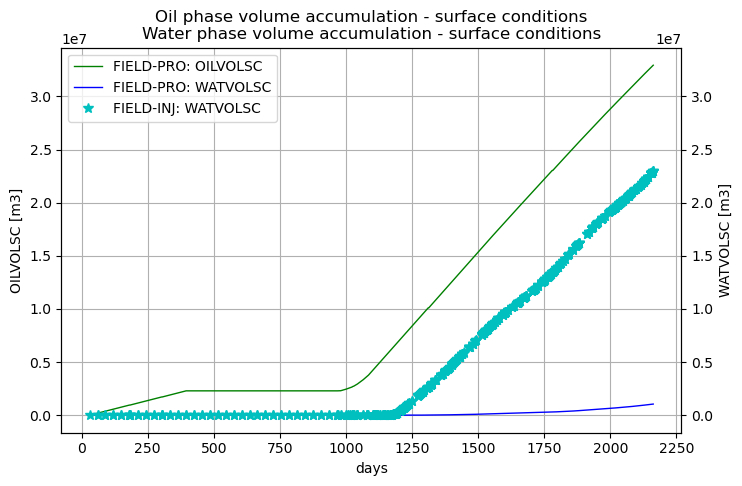

In [63]:
get_data_and_plot(element_type='group', property_names=['OILVOLSC','WATVOLSC'], element_names=['FIELD-PRO','FIELD-INJ'],
                  keep_all_zeros_series=False,
                  line_styles=['g-','b-','g-','c*'],
                  use_secondary_axis=True,
                  keep_legend_outside=False)

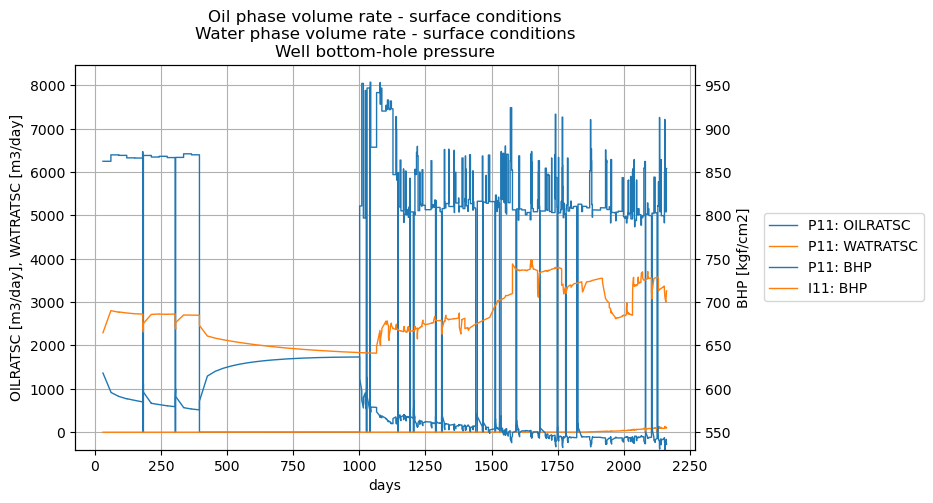

In [65]:
get_data_and_plot(element_type='well', property_names=['OILRATSC','WATRATSC', 'BHP'], element_names=['P11','I11'],
                  keep_all_zeros_series=False,
                  keep_legend_outside=True,
                  use_secondary_axis=True)

## Grid Properties

In [66]:
ni, nj, nk, n_active, _ = _get_grid_sizes()
n_cells = ni*nj*nk
print(f'{ni}x{nj}x{nk} = {format(n_cells,",")} cells')
print(f'active: {format(n_active,",")} cells ({(n_active/n_cells*100):.2f}%)')

47x39x291 = 533,403 cells
active: 67,241 cells (12.61%)


* Função para retornar i,j,k em função do cell_#
* Retornar dados de grid com o get_data
* Fazer interpolação de dados de grid
* Distinguir entre propriedades de malha completos e só de células ativas
* Montar array 3D com dados de malha completos
* Montar array 3D com dados de malha só de células ativas

* Retornar lista de propriedades com as funções get_properties
    * Limitar às propriedades de grid completas e de células ativas.
* Get_elements vai ser apenas MATRIX

* Montar propriedades específicas de coordenadas de célula.

## Get Coordinates

In [ ]:
_CHUNK_SIZE = 1200

def expand_list(original_list, items=1):
    expanded_list = []
    for value in original_list:
        value_shift = (value-1)*items
        expanded_list.append(value_shift)
        for new_value in range(value_shift + 1, value_shift + items):
            expanded_list.append(new_value)
    return expanded_list

def get_dataset_data(dataset, values_list):
    if not is_iterable(values_list):
        return dataset[values_list]
    x_ordered = list(set(values_list)).copy()
    x_ordered.sort()
    sub_x_ordered = np.array_split(x_ordered, int(len(x_ordered)/_CHUNK_SIZE)+1)
    y_dict = dict()
    for x in sub_x_ordered:
        y = dataset[x]
        for x,y in zip(x, y):
            y_dict[x] = y
    return  np.array([y_dict[x] for x in values_list])

def get_cel_number(i,j,k, can_be_iterable=True):
    if can_be_iterable and is_iterable(i):
        return [ii + ni*(jj-1 + (kk-1)*nj) for (ii,jj,kk) in zip(i,j,k)]
    return i + ni*(j-1 + (k-1)*nj)

def get_nodes_index(i,j=None,k=None, can_be_iterable=True):
    dataset = f['SpatialProperties/000000/GRID/BLOCKS']
    if can_be_iterable and is_iterable(i):
        if j is not None:
            i = get_cel_number(i,j,k)
        y = get_dataset_data(dataset, expand_list(i, 8))
        return np.reshape(y, (-1, 8))
    if j is not None:
        i = get_cel_number(i,j,k)
    return dataset[(i-1)*8:i*8]

def get_cell_coordinates(i,j=None,k=None, can_be_iterable=True):
    dataset = f['SpatialProperties/000000/GRID/NODES']
    if can_be_iterable and is_iterable(i):
        if j is not None:
            i = get_cel_number(i,j,k)
        nodes = get_nodes_index(i)
        y = get_dataset_data(dataset, expand_list(nodes.flatten(), 3))
        return y.reshape((len(i), 8, 3))
    if j is not None:
        i = get_cel_number(i,j,k)
    return [dataset[(n-1)*3:n*3] for n in get_nodes_index(i)]

In [ ]:
size = 2000
i_list = list(np.random.randint(low=1, high=ni, size=size))
j_list = list(np.random.randint(low=1, high=nj, size=size))
if nk>1:
    k_list = list(np.random.randint(low=1, high=nk, size=size))
else:
    k_list = [1]*size

cells = get_cel_number(i_list,j_list,k_list)

start_time = datetime.now()
x = get_cell_coordinates(cells)
end_time = datetime.now()
print(f'Elapsed time: {end_time - start_time}')

KeyError: "Unable to open object (object 'NODES' doesn't exist)"

In [ ]:
def time_function(func, size):
    i_list = list(np.random.randint(low=1, high=ni, size=size))
    j_list = list(np.random.randint(low=1, high=nj, size=size))
    k_list = list(np.random.randint(low=1, high=nk, size=size))
    cells = get_cel_number(i_list,j_list,k_list)

    start_time = datetime.now()
    _ = func(cells)
    end_time = datetime.now()
    # print(f'{s} elemts: {end_time - start_time} ({(end_time - start_time)/s*1000} per 1000 elemts)')
    return (end_time - start_time)/size*1000

def time_function_sens(func, arguments_sizes):
    t = []
    for s in arguments_sizes:
        t.append(time_function(func, s))
    return t

def time_function_opt(func, min_val, max_val, fmin_val=None, fmax_val=None):
    if fmin_val is None:
        fmin_val = time_function(func, min_val)
        print(f'{min_val} => {fmin_val}')
    if fmax_val is None:
        fmax_val = time_function(func, max_val)
        print(f'{max_val} => {fmax_val}')
    a_val = int((2*min_val + max_val)/3)
    b_val = int((min_val + 2*max_val)/3)
    if a_val == min_val or b_val == max_val:
        if fmin_val < fmax_val:
            return min_val
        else:
            return max_val
    fa_val = time_function(func, a_val)
    fb_val = time_function(func, b_val)
    print(f'{a_val} => {fa_val}')
    print(f'{b_val} => {fb_val}')
    if fa_val < fb_val:
        return time_function_opt(func, min_val, b_val, fmin_val, fb_val)
    else:
        return time_function_opt(func, a_val, max_val, fa_val, fmax_val)


# t = time_function_sens(get_nodes_index, [100, 200, 500, 1000, 2000, 5000])
